In [48]:
from pathlib import Path
import duckdb
import polars as pl
from datetime import datetime
from transformers import (
    AutoTokenizer, 
)
from core_pro.ultilities import update_df
import sys
sys.path.extend([str(Path.home() / 'PycharmProjects/model_train')])

from src.model_train.func import MultiLabels, export_to_md
from src.model_train.data_loading import TrainDistribution
from src.model_train.pipeline_train import Pipeline

In [2]:
path = Path('/media/kevin/data_4t/cx_product_review/training_data')
save_path = path / 'dataset/all_topic'

file = path / 'train_2024_11_12.parquet'
l1 = ['product_quality', 'pricing', 'delivery_service', 'packaging', 'seller_service', 'listing_accuracy', 'order_accuracy', 'irrelevant']
labels = [f'category_{i}' for i in l1] + [f'issue_{i}' for i in l1]

query = f"""
select distinct 
item_id
, item_name
, comment_id
, comment
, comment_clean
, {'\n, '.join(f'coalesce({i}, 0) {i}' for i in labels)}
from read_parquet('{file}')
"""
df = duckdb.sql(query).pl()
print(df.shape, df['comment_id'].n_unique())

(117193, 20) 117193


In [3]:
df.head()

item_id,item_name,comment_id,comment,category_product_quality,category_pricing,category_delivery_service,category_packaging,category_seller_service,category_listing_accuracy,category_order_accuracy,category_irrelevant,issue_product_quality,issue_pricing,issue_delivery_service,issue_packaging,issue_seller_service,issue_listing_accuracy,issue_order_accuracy,issue_irrelevant
i64,str,u64,str,i64,i64,i64,i64,i64,i64,i64,i32,i64,i64,i64,i64,i64,i64,i64,i32
13313658151,"""Áo gió nam nữ vải tráng chống …",6603730773,"""Sản phâm may rất cẩu thả may t…",0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0
115543274,"""MÁY LÀM TÓC 3 TRONG 1 SONAR 71…",438432450,""" Rất không đáng tiền""",0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
8820961536,"""Bột đậu đỏ hữu cơ UMIHOME 40G …",15024510021,"""Bột đậu đỏ nguyên chất UMIHOME…",1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
8587034871,"""[DIỆN MẠO MỚI] Sữa Rửa Mặt Sim…",8832835146,"""Giao hàng nhanh, đóng gói cẩn …",0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1
7327824581,"""Râu mực xào cay Tứ Xuyên""",14227710047,"""Mùi quá, ăn ko hợp vị mik lm""",1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


INFO | __init__ | [Data Loading]
INFO | split_train_valid_test | -> Shape Train: (75003, 20), Valid: (18751, 20), Test: (23439, 20)


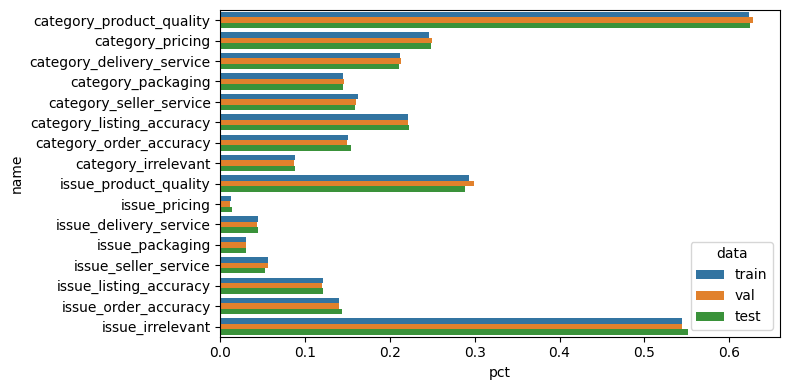

In [4]:
dist_check = TrainDistribution(df, labels)
train, val, test = dist_check.split_train_valid_test(test_size=.2)
dist_check.check()

In [5]:
# col = ['comment_id', 'comment'] + labels
col = ['comment_id', 'comment_clean'] + labels
ds_train, ds_test, ds_val = dist_check.df_to_dataset(col, show_index=3, save_path=save_path)

INFO | df_to_dataset | -> Show data example: 3
        Train: {'comment_id': 15201669157, 'comment': 'kẹo ko giống với mô tả', 'category_product_quality': 0, 'category_pricing': 0, 'category_delivery_service': 0, 'category_packaging': 0, 'category_seller_service': 0, 'category_listing_accuracy': 1, 'category_order_accuracy': 0, 'category_irrelevant': 0, 'issue_product_quality': 0, 'issue_pricing': 0, 'issue_delivery_service': 0, 'issue_packaging': 0, 'issue_seller_service': 0, 'issue_listing_accuracy': 1, 'issue_order_accuracy': 0, 'issue_irrelevant': 0}
        Test: {'comment_id': 15795193121, 'comment': 'dép mới đi đã bị mờ hết hình', 'category_product_quality': 1, 'category_pricing': 0, 'category_delivery_service': 0, 'category_packaging': 0, 'category_seller_service': 0, 'category_listing_accuracy': 0, 'category_order_accuracy': 0, 'category_irrelevant': 0, 'issue_product_quality': 1, 'issue_pricing': 0, 'issue_delivery_service': 0, 'issue_packaging': 0, 'issue_seller_service': 0,

Saving the dataset (0/1 shards):   0%|          | 0/75003 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/23439 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/18751 [00:00<?, ? examples/s]

In [6]:
pretrain_name = 'bkai-foundation-models/vietnamese-bi-encoder'
tokenizer = AutoTokenizer.from_pretrained(pretrain_name)

In [7]:
train_encoded_dataset, test_encoded_dataset, val_encoded_dataset = dist_check.dataset_to_train(tokenizer)

Map:   0%|          | 0/75003 [00:00<?, ? examples/s]

Map:   0%|          | 0/18751 [00:00<?, ? examples/s]

Map:   0%|          | 0/23439 [00:00<?, ? examples/s]

INFO | dataset_to_train | -> Show token example: 0
        Keys: dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
        Token: <s> Rất khó chịu khi mà ship giao hàng không lấy một cuộc gọi nào. Lỡ giao nhầm, giao sai thì mất công, rất phiền. Đơn thứ 2 rồi mà vẫn vậy. </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
        Labels: ['category_delivery_service', 'issue_delivery_service']



In [8]:
pipe = Pipeline(pretrain_name=pretrain_name, id2label=dist_check.id2label, label2id=dist_check.label2id)

time_now = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
folder = path / f'model_multi_labels_all/{pretrain_name.split('/')[-1]}/{time_now}'
config = dict(    
    log_step=100,
    num_train_epochs=5,
    learning_rate=1e-4,
)
trainer = pipe.train(
    folder=folder, 
    train=train_encoded_dataset,
    val=val_encoded_dataset,
    **config
)

INFO | _load_model | Pretrain: bkai-foundation-models/vietnamese-bi-encoder


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at bkai-foundation-models/vietnamese-bi-encoder and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
100,0.450300,0.292557,0.674493,0.780436,0.209056
200,0.237100,0.191585,0.822158,0.885732,0.460455
300,0.176600,0.160077,0.846943,0.901716,0.524932
400,0.146300,0.148285,0.855094,0.907395,0.545144
500,0.130100,0.142953,0.859872,0.909009,0.564343
600,0.120300,0.141290,0.861063,0.911076,0.564663
700,0.112600,0.141042,0.861522,0.911720,0.567543


***** train metrics *****
  epoch                    =        5.0
  total_flos               =  8975166GF
  train_loss               =     0.1921
  train_runtime            = 0:02:54.94
  train_samples_per_second =   2143.632
  train_steps_per_second   =      4.201


In [9]:
valid_result = trainer.predict(val_encoded_dataset)
valid_report = MultiLabels().classification_report_html(
    result=valid_result.predictions, 
    labels=valid_result.label_ids, 
    target_names=labels, 
    show=True
)

                           precision    recall  f1-score   support

 category_product_quality       0.89      0.93      0.91     11787
         category_pricing       0.86      0.74      0.79      4673
category_delivery_service       0.92      0.92      0.92      4004
       category_packaging       0.84      0.86      0.85      2726
  category_seller_service       0.79      0.77      0.78      3006
category_listing_accuracy       0.83      0.83      0.83      4149
  category_order_accuracy       0.84      0.80      0.82      2798
      category_irrelevant       0.85      0.77      0.80      1626
    issue_product_quality       0.86      0.87      0.87      5604
            issue_pricing       0.63      0.22      0.33       206
   issue_delivery_service       0.82      0.79      0.80       817
          issue_packaging       0.72      0.68      0.70       568
     issue_seller_service       0.80      0.77      0.79      1054
   issue_listing_accuracy       0.78      0.73      0.75     

/home/kevin/miniforge3/envs/llm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kevin/miniforge3/envs/llm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [12]:
test_result = trainer.predict(test_encoded_dataset)
test_report = MultiLabels().classification_report_html(
    result=test_result.predictions, 
    labels=test_result.label_ids, 
    target_names=labels, 
    show=True
)

                           precision    recall  f1-score   support

 category_product_quality       0.89      0.93      0.91     14648
         category_pricing       0.85      0.73      0.79      5820
category_delivery_service       0.91      0.92      0.92      4928
       category_packaging       0.85      0.86      0.86      3381
  category_seller_service       0.79      0.76      0.77      3729
category_listing_accuracy       0.83      0.82      0.83      5205
  category_order_accuracy       0.83      0.80      0.81      3600
      category_irrelevant       0.83      0.74      0.79      2071
    issue_product_quality       0.84      0.86      0.85      6769
            issue_pricing       0.74      0.23      0.35       314
   issue_delivery_service       0.82      0.74      0.78      1044
          issue_packaging       0.73      0.69      0.71       718
     issue_seller_service       0.79      0.77      0.78      1242
   issue_listing_accuracy       0.79      0.72      0.76     

/home/kevin/miniforge3/envs/llm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kevin/miniforge3/envs/llm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [11]:
path_md = str(path / f'model_multi_labels_all/{pretrain_name.split('/')[-1]}/result_{time_now}.md')
export_to_md(path_md, config, valid_report, test_report)

In [18]:
output_test = MultiLabels().post_process(test_result.predictions)
output_test

array([[0., 1., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [17]:
test_result.label_ids

array([[1., 1., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [40]:
import numpy as np
allcheck = np.all(output_test == test_result.label_ids, axis=1)
allcheck

array([False,  True, False, ...,  True, False,  True])

In [51]:
def post_process_report_view(data: pl.DataFrame, labels_name: list, columns_name: str):
    return (
        data.with_columns(
            pl.when(pl.col(i) == 1).then(pl.lit(i)).otherwise(None).alias(i)
            for i in labels
        )
        .with_columns(
            pl.concat_list(labels).list.join('\n').alias(columns_name)
        )
    )

In [52]:
report_test_pred = (
    pl.DataFrame(output_test, schema=labels)
    .pipe(post_process_report_view, labels_name=labels, columns_name='pred_labels')
    .with_columns(pl.Series('all_labels', allcheck))
    .drop(labels)
)

In [53]:
report_test_truth = (
    test
    .pipe(post_process_report_view, labels_name=labels, columns_name='ground_truth')
)
report = pl.concat([report_test_truth, report_test_pred], how='horizontal')

In [54]:
report

item_id,item_name,comment_id,comment,category_product_quality,category_pricing,category_delivery_service,category_packaging,category_seller_service,category_listing_accuracy,category_order_accuracy,category_irrelevant,issue_product_quality,issue_pricing,issue_delivery_service,issue_packaging,issue_seller_service,issue_listing_accuracy,issue_order_accuracy,issue_irrelevant,ground_truth,pred_labels,all_labels
i64,str,u64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,bool
23786333770,"""ĐẦM DAI DÂY FOM XOÈ NHẸ NHÀNG …",15183300447,"""Màu sắc:dden Chất liệu:vair co…","""category_product_quality""","""category_pricing""",null,null,null,"""category_listing_accuracy""",null,null,null,null,null,null,null,"""issue_listing_accuracy""",null,null,"""category_product_quality categ…","""category_pricing category_deli…",false
25204390241,"""Mascara Màu Đen Chuốt Dài Mi C…",15907207474,"""Độ bền màu:mãi không khô được …","""category_product_quality""",null,null,null,null,null,null,null,"""issue_product_quality""",null,null,null,null,null,null,null,"""category_product_quality issue…","""category_product_quality issue…",true
5142949381,"""Cốm dẹp xanh làm chả, chiên tô…",12956349018,"""Chỉ toàn là màu""","""category_product_quality""",null,null,null,null,"""category_listing_accuracy""",null,null,null,null,null,null,null,"""issue_listing_accuracy""",null,null,"""category_product_quality categ…","""category_order_accuracy issue_…",false
25812730276,"""Dép Nam Mùa Hè Chống Trơn Trượ…",15795193121,"""dép mới đi đã bị mờ hết hình""","""category_product_quality""",null,null,null,null,null,null,null,"""issue_product_quality""",null,null,null,null,null,null,null,"""category_product_quality issue…","""category_product_quality categ…",false
7816164195,"""Toàn Quốc [E-Voucher] NOW Giảm…",2136096275,"""Giá rẻ giá rẻ Giá rẻ giá rẻ Gi…",null,"""category_pricing""",null,null,null,null,null,null,null,null,null,null,null,null,null,"""issue_irrelevant""","""category_pricing issue_irrelev…","""category_pricing issue_irrelev…",true
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
4780786068,"""[CÓ SẴN] Vòng Tay Cuff CK Nam …",5274985979,"""Xinhh lắm nha mn nên muaaa Gi…",null,"""category_pricing""","""category_delivery_service""",null,null,null,null,null,null,null,null,null,null,null,null,"""issue_irrelevant""","""category_pricing category_deli…","""category_delivery_service issu…",false
23545649197,"""Derf Cọ Tô Son Môi Cán Ngắn Có…",14721904548,"""Bao bì/Mẫu mã:màu hồng và trắn…","""category_product_quality""",null,null,"""category_packaging""",null,null,null,null,"""issue_product_quality""",null,null,null,null,null,null,null,"""category_product_quality categ…","""category_product_quality categ…",false
6629562971,"""BALO ULZZANG BASIC ( chống nướ…",8912371264,"""Chất lượng sản phẩm khá ổn mà …","""category_product_quality""",null,null,null,"""category_seller_service""",null,null,null,null,null,null,null,"""issue_seller_service""",null,null,null,"""category_product_quality categ…","""category_product_quality categ…",true


In [59]:
sh = '1ZEPo6kkI1zc_H-WTA5CoEYsbOjsXicrRAACaCjM6D2U'
update_df(report, 'test', sh)

13:58:11 | 🐶 Sheet: Update values at: test!A1:W


In [57]:
report.filter(issue_pricing='issue_pricing')

item_id,item_name,comment_id,comment,category_product_quality,category_pricing,category_delivery_service,category_packaging,category_seller_service,category_listing_accuracy,category_order_accuracy,category_irrelevant,issue_product_quality,issue_pricing,issue_delivery_service,issue_packaging,issue_seller_service,issue_listing_accuracy,issue_order_accuracy,issue_irrelevant,ground_truth,pred_labels,all_labels
i64,str,u64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,bool
2900397939,"""Kệ để dao thớt đũa Inox""",11141586461,"""Giao hàng siêu nhanh. Mẫu mã đ…","""category_product_quality""","""category_pricing""","""category_delivery_service""",null,null,null,null,null,"""issue_product_quality""","""issue_pricing""",null,null,null,null,null,null,"""category_product_quality categ…","""category_product_quality categ…",false
18302113824,"""[CHẤT LƯỢNG CAO] Kệ góc tường,…",10065004490,"""KỆ LỎNG LẺO CHÂN KỆ YẾU ỚT PHẢ…","""category_product_quality""","""category_pricing""",null,null,null,null,null,null,"""issue_product_quality""","""issue_pricing""",null,null,null,null,null,null,"""category_product_quality categ…","""category_product_quality categ…",false
6706694489,"""Đầm Sơ Mi Sọc Nữ Thu Đông Dài …",2847238283,"""Chất liệu rất xấu, pha nilon n…","""category_product_quality""","""category_pricing""","""category_delivery_service""",null,null,null,null,null,"""issue_product_quality""","""issue_pricing""",null,null,null,null,null,null,"""category_product_quality categ…","""category_product_quality categ…",false
22358045396,"""BỘ NHUNG CHA.NEL Hàng Hót đủ m…",14416457225,"""May ẩu, chỉ thừa quá nhiều. Kh…",null,"""category_pricing""",null,null,null,null,"""category_order_accuracy""",null,null,"""issue_pricing""",null,null,null,null,"""issue_order_accuracy""",null,"""category_pricing category_orde…","""category_pricing issue_pricing""",false
8554614088,"""Mắt Kính Gọng Vuông Cực Đẹp 2 …",7428070969,"""Sản phẩm rất chất, rất như đầ…","""category_product_quality""","""category_pricing""",null,null,null,null,null,null,"""issue_product_quality""","""issue_pricing""",null,null,null,null,null,null,"""category_product_quality categ…","""category_product_quality categ…",false
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
25155678186,"""Áo Khoác Hoodie DAPPERANDMORE …",15664046796,"""kh xứng đáng với giá tiền mấy,…","""category_product_quality""","""category_pricing""",null,null,null,null,null,null,"""issue_product_quality""","""issue_pricing""",null,null,null,null,null,null,"""category_product_quality categ…","""category_product_quality categ…",false
10765879726,"""[Chính hãng]Toner miếng không …",14731009801,"""Đăng ký gói ST5K không thành c…",null,"""category_pricing""",null,null,null,null,null,null,null,"""issue_pricing""",null,null,null,null,null,null,"""category_pricing issue_pricing""","""category_pricing""",false
1718293372,"""Áo Lót Nhật Viền Cực Trẻ Trung""",988432870,"""Ko mặc dc,,,ko dang tiền ""","""category_product_quality""","""category_pricing""",null,null,null,null,null,null,"""issue_product_quality""","""issue_pricing""",null,null,null,null,null,null,"""category_product_quality categ…","""category_pricing issue_pricing""",false


In [58]:
report.shape

(23439, 23)